# Modeling

This notebook will guide you through the process of loading heterogeneous graphs and training models. The heterogeneous graph is based on Deep Graph Library (DGL) implementation, and the training process is based on PyTorch implementation.

The CPU is recommended for training when the equipment allows it. If you need to use GPU, please install GPU-based DGL separately.

## Colab setting

If you want to train in Colab, please run both cells first and mount to the corresponding path.

from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/graph-fraud-detection/"
os.chdir(cur_path)
!pwd

In [ ]:
!pip install dgl
#-cu101

## Training (Detailed)

Besides the approach mentioned before, you can also use this detailed approach.

### Prepare environment

In [1]:
import os
import sys
import glob

os.environ['DGLBACKEND'] = 'pytorch'

import torch as th
import dgl
import numpy as np

from gnn.estimator_fns import *
from gnn.graph_utils import *
from gnn.data import *
from gnn.utils import *
from gnn.pytorch_model import *
from train import *

DLG version: 1.0.1


### Load data

Recall the edges we defined before and the csv files we used to save them.

In [2]:
file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

To train the graph neural network, we need to define a few hyperparameters that determine properties such as the class of graph neural network models we will be using, the network architecture and the optimizer and optimization parameters.

Here we're setting only a few of the hyperparameters, to see all the hyperparameters and their default values, see `gnn/estimator_fns.py`. The parameters set below are:

- **nodes** is the name of the file that contains the node_ids of the target nodes and the node features.
- **edges** is a regular expression that when expanded lists all the filenames for the edgelists
- **labels** is the name of the file tha contains the target node_ids and their labels
- **model** specify which graph neural network to use, this should be set to r-gcn

The following hyperparameters can be tuned and adjusted to improve model performance

- **batch-size** is the number nodes that are used to compute a single forward pass of the GNN
- **embedding-size** is the size of the embedding dimension for non target nodes
- **n-neighbors** is the number of neighbours to sample for each target node during graph sampling for mini-batch training
- **n-layers** is the number of GNN layers in the model
- **n-epochs** is the number of training epochs for the model training job
- **optimizer** is the optimization algorithm used for gradient based parameter updates
- **lr** is the learning rate for parameter updates

### Generate graph

In [3]:
print('numpy version:{} PyTorch version:{} DGL version:{}'.format(np.__version__,
                                                                    th.__version__,
                                                                    dgl.__version__))

args = parse_args()
print(args)

numpy version:1.24.2 PyTorch version:1.13.1+cu117 DGL version:1.0.1
Namespace(training_dir='./data', model_dir='./model/2023_05_19_13_36_00', output_dir='./output', nodes='features.csv', target_ntype='TransactionID', edges='relation*', labels='tags.csv', new_accounts='test.csv', compute_metrics=True, threshold=0, num_gpus=0, optimizer='adam', lr=0.01, n_epochs=200, n_hidden=16, n_layers=2, weight_decay=0.0001, dropout=0.2, embedding_size=360, n_heads=8, alpha=0.2)


In [4]:
args.edges = edges

args.edges = get_edgelists('relation*', args.training_dir)

g, features, target_id_to_node, id_to_node = construct_graph(args.training_dir,
                                                                args.edges,
                                                                args.nodes,
                                                                args.target_ntype)

mean, stdev, features = normalize(th.from_numpy(features))

print('feature mean shape:{}, std shape:{}'.format(mean.shape, stdev.shape))

Getting relation graphs from the following edge lists : ['relation_TransactionID_edgelist.csv', 'relation_R_emaildomain_edgelist.csv', 'relation_P_emaildomain_edgelist.csv', 'relation_ProductCD_edgelist.csv', 'relation_id_38_edgelist.csv', 'relation_id_37_edgelist.csv', 'relation_id_36_edgelist.csv', 'relation_id_35_edgelist.csv', 'relation_id_34_edgelist.csv', 'relation_id_33_edgelist.csv', 'relation_id_32_edgelist.csv', 'relation_id_31_edgelist.csv', 'relation_id_30_edgelist.csv', 'relation_id_29_edgelist.csv', 'relation_id_28_edgelist.csv', 'relation_id_27_edgelist.csv', 'relation_id_26_edgelist.csv', 'relation_id_25_edgelist.csv', 'relation_id_24_edgelist.csv', 'relation_id_23_edgelist.csv', 'relation_id_22_edgelist.csv', 'relation_id_21_edgelist.csv', 'relation_id_20_edgelist.csv', 'relation_id_19_edgelist.csv', 'relation_id_18_edgelist.csv', 'relation_id_17_edgelist.csv', 'relation_id_16_edgelist.csv', 'relation_id_15_edgelist.csv', 'relation_id_14_edgelist.csv', 'relation_id_13_

feature mean shape:torch.Size([390]), std shape:torch.Size([390])


In [5]:
g.nodes['target'].data['features'] = features

print("Getting labels")
n_nodes = g.number_of_nodes('target')

labels, _, test_mask = get_labels(target_id_to_node,
                                            n_nodes,
                                            args.target_ntype,
                                            os.path.join(args.training_dir, args.labels),
                                            os.path.join(args.training_dir, args.new_accounts))
print("Got labels")

labels = th.from_numpy(labels).float()
test_mask = th.from_numpy(test_mask).float()

n_nodes = th.sum(th.tensor([g.number_of_nodes(n_type) for n_type in g.ntypes]))
n_edges = th.sum(th.tensor([g.number_of_edges(e_type) for e_type in g.etypes]))

print("""----Data statistics------'
            #Nodes: {}
            #Edges: {}
            #Features Shape: {}
            #Labeled Test samples: {}""".format(n_nodes,
                                                    n_edges,
                                                    features.shape,
                                                    test_mask.sum()))

Getting labels
Got labels
----Data statistics------'
            #Nodes: 726345
            #Edges: 19518802
            #Features Shape: torch.Size([590540, 390])
            #Labeled Test samples: 118108.0


### Start training

The training process and result will be saved in the same folder. 

In [6]:
if args.num_gpus:
    cuda = True
    device = th.device('cuda:0')
else:
    cuda = False
    device = th.device('cpu')

Initializing Model
Initialized Model
Starting Model training


/home/mtech/2021/n.kalyani/.conda/envs/kalyani/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 00000, Time(s) 16.0350, Loss 0.3842, F1 0.0000 
Epoch 00001, Time(s) 15.2273, Loss 1.0864, F1 0.0004 
Epoch 00002, Time(s) 14.0008, Loss 0.6801, F1 0.0374 
Epoch 00003, Time(s) 13.1069, Loss 0.3611, F1 0.1802 
Epoch 00004, Time(s) 12.6811, Loss 0.7475, F1 0.2017 
Epoch 00005, Time(s) 12.3984, Loss 0.2137, F1 0.0209 
Epoch 00006, Time(s) 12.1071, Loss 0.2300, F1 0.0090 
Epoch 00007, Time(s) 11.9267, Loss 0.2695, F1 0.0252 
Epoch 00008, Time(s) 11.7152, Loss 0.2636, F1 0.0415 
Epoch 00009, Time(s) 11.5663, Loss 0.2315, F1 0.0852 
Epoch 00010, Time(s) 11.4168, Loss 0.2109, F1 0.1160 
Epoch 00011, Time(s) 11.3541, Loss 0.1816, F1 0.1360 
Epoch 00012, Time(s) 11.3040, Loss 0.1554, F1 0.2039 
Epoch 00013, Time(s) 11.4178, Loss 0.1397, F1 0.3071 
Epoch 00014, Time(s) 11.8890, Loss 0.1451, F1 0.3073 
Epoch 00015, Time(s) 12.4993, Loss 0.1489, F1 0.2728 
Epoch 00016, Time(s) 13.2706, Loss 0.1362, F1 0.2054 
Epoch 00017, Time(s) 13.7254, Loss 0.1345, F1 0.1785 
Epoch 00018, Time(s) 13.7718

Epoch 00152, Time(s) 121.0901, Loss 0.0896, F1 0.5125 
Epoch 00153, Time(s) 121.4649, Loss 0.0842, F1 0.5486 
Epoch 00154, Time(s) 121.8613, Loss 0.0881, F1 0.4759 
Epoch 00155, Time(s) 122.1974, Loss 0.0859, F1 0.4709 
Epoch 00156, Time(s) 122.5139, Loss 0.0865, F1 0.5231 
Epoch 00157, Time(s) 122.8461, Loss 0.0841, F1 0.5197 
Epoch 00158, Time(s) 123.1393, Loss 0.0874, F1 0.4909 
Epoch 00159, Time(s) 123.4697, Loss 0.0831, F1 0.4974 
Epoch 00160, Time(s) 123.8132, Loss 0.0857, F1 0.5003 
Epoch 00161, Time(s) 124.1099, Loss 0.0843, F1 0.5415 
Epoch 00162, Time(s) 124.4464, Loss 0.0844, F1 0.5256 
Epoch 00163, Time(s) 124.7681, Loss 0.0841, F1 0.4605 
Epoch 00164, Time(s) 125.1217, Loss 0.0848, F1 0.5121 
Epoch 00165, Time(s) 125.4891, Loss 0.0823, F1 0.5647 
Epoch 00166, Time(s) 125.7984, Loss 0.0850, F1 0.5038 
Epoch 00167, Time(s) 126.1306, Loss 0.0832, F1 0.4927 
Epoch 00168, Time(s) 126.4432, Loss 0.0831, F1 0.5519 
Epoch 00169, Time(s) 126.7539, Loss 0.0832, F1 0.5357 
Epoch 0017

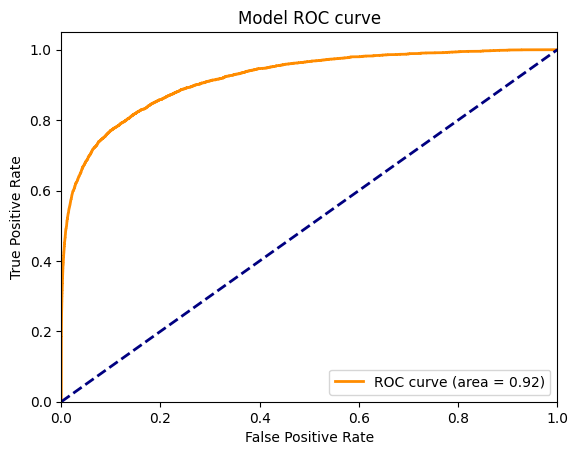

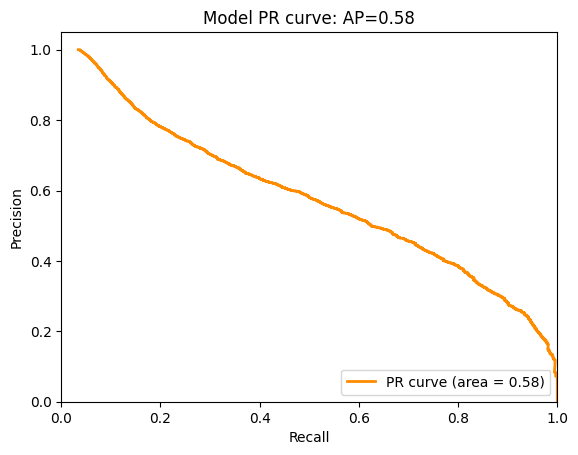

In [7]:
print("Initializing Model")
in_feats = features.shape[1]
n_classes = 2

ntype_dict = {n_type: g.number_of_nodes(n_type) for n_type in g.ntypes}

model = get_model(ntype_dict, g.etypes, vars(args), in_feats, n_classes, device)
print("Initialized Model")

features = features.to(device)

labels = labels.long().to(device)
test_mask = test_mask.to(device)
# g = g.to(device)

loss = th.nn.CrossEntropyLoss()

# print(model)
optim = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

print("Starting Model training")

initial_record()

model, class_preds, pred_proba = train_fg(model, optim, loss, features, labels, g, g,
                                            test_mask, device, 200,
                                            args.threshold,  args.compute_metrics)
print("Finished Model training")

print("Saving model") 

if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)

save_model(g, model, args.model_dir, id_to_node, mean, stdev)
print("Model and metadata saved")

In [8]:
results = pd.read_csv('./output1/results.txt')
results.drop(['Accuracy'], axis=1,inplace=True)
results.head()

,Epoch,Time(s),Loss,F1
0,0,16.0350,0.3842,0.0000
1,1,15.2273,1.0864,0.0004
2,2,14.0008,0.6801,0.0374
3,3,13.1069,0.3611,0.1802
4,4,12.6811,0.7475,0.2017


In [9]:
import matplotlib.pyplot as plt

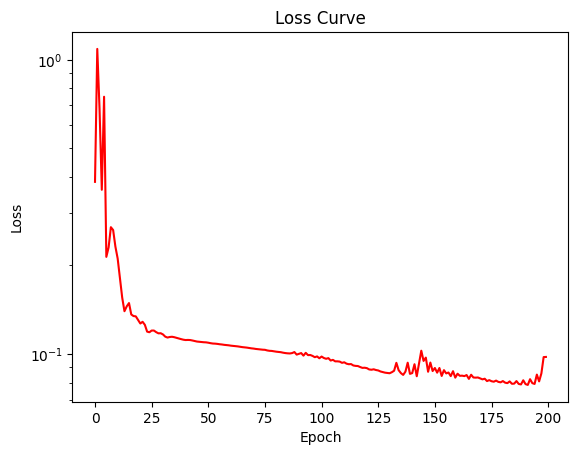

In [10]:
plt.plot(results['Epoch'],results['Loss'],color='r')
plt.yscale('log')
plt.xlabel('Epoch')        
plt.ylabel('Loss')   
plt.title("Loss Curve")
plt.savefig('./output1/loss.jpg')
plt.show()


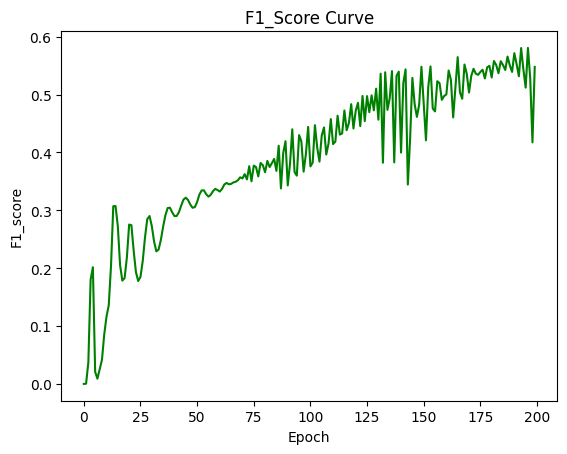

In [11]:
plt.plot(results['Epoch'],results['F1'],color='g')
plt.xlabel('Epoch')        
plt.ylabel('F1_score')   
plt.title("F1_Score Curve")
plt.savefig('./output1/F1_score.jpg')
plt.show()

In [12]:
#average time in second
time_avg=results['Time(s)'].mean()
print("Average time per epochs:",time_avg,"sec")

Average time per epochs: 73.591177 sec
